In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

# Charger les données MNIST 
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=torchvision.transforms.ToTensor(), download=True)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=torchvision.transforms.ToTensor(), download=True)

# Définir le modèle 
"""Le modèle est défini dans la classe Net. 
Il s'agit d'un réseau de neurones à trois couches entièrement connectées, où chaque couche est définie comme une couche 
linéaire suivie d'une fonction d'activation ReLU. La dernière couche a 10 sorties correspondant aux chiffres de 0 à 9."""

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(784, 512) """La première couche linéaire self.fc1 a une entrée de taille 784 
                                            (28x28 pixels de l'image MNIST) et une sortie de taille 512."""
        self.fc2 = nn.Linear(512, 256)"""La deuxième couche linéaire self.fc2 a une entrée de taille 512 
                                        et une sortie de taille 256."""
        self.fc3 = nn.Linear(256, 10) """La dernière couche linéaire self.fc3 a une entrée de taille 256 
                                        et une sortie de taille 10 ,ce qui correspondant aux 10 classes possibles pour les images MNIST."""

"""La méthode forward du modèle effectue le passage avant à travers les couches, 
en utilisant la méthode view pour remodeler le tenseur d'entrée à la bonne taille."""
    def forward(self, x):
        x = x.view(-1, 784)
        x = nn.functional.relu(self.fc1(x))
        x = nn.functional.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = Net()

# Définir la fonction de perte et l'optimiseur
""" la fonction de perte CrossEntropyLoss est définie, qui est couramment utilisée pour la classification multiclasse. 
L'optimiseur Adam est également défini avec un taux d'apprentissage de 0,001 ->
la taille des pas que l'algorithme d'optimisation prend pour ajuster les poids du modèle pendant l'entraînement."""

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Entraînement du modèle
"""Le modèle est entraîné sur 10 époques. Dans chaque époque, le code itère sur tous les lots de données d'entraînement 
et effectue la propagation avant (forward pass), le calcul de la perte (loss), la propagation arrière (backward pass) 
et l'optimisation des poids. Après chaque époque, le code évalue la précision du modèle sur les données de test en calculant 
le pourcentage de prédictions correctes."""
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

for epoch in range(10):
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    # Calcul de la précision sur les données de test
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
    total = 0
    correct = 0
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Epoch %d: Accuracy on test set: %d %%' % (epoch+1, 100 * correct / total))

# Élagage basé sur l'erreur
"""Le code procède ensuite à un élagage (ou pruning) basé sur l'erreur. Le nombre d'itérations d'élagage est défini par la 
variable pruning_iterations. Dans chaque itération, le code calcule l'erreur pour chaque couche en utilisant la fonction 
torch.abs pour obtenir la valeur absolue du gradient et de la valeur des poids. Les erreurs sont concaténées et triées par 
ordre décroissant. Le code utilise ensuite la fonction torch.quantile pour définir un seuil de prune (threshold) basé sur le 
taux de pruning défini par la variable pruning_rate. Les poids correspondant aux erreurs supérieures au seuil sont supprimés 
en les réinitialisant à zéro. La précision du modèle est évaluée après chaque itération d'élagage."""
num_pruned = 0
pruning_rate = 0.2
pruning_iterations = 10

for iteration in range(pruning_iterations):
    # Calcul de l'erreur pour chaque couche
    errors = []
    for name, param in model.named_parameters():
        if 'weight' in name:
            error = torch.abs(param.grad) * torch.abs(param.data)
            errors.append(error.view(-1))

    # Reforme la première erreur en une forme appropriée
    errors[0] = errors[0].view(-1)

    # Concaténation des erreurs et tri par ordre décroissant
    all_errors = torch.cat(errors)
    threshold = torch.quantile(all_errors, pruning_rate)

    # Suppression des poids correspondant aux erreurs supérieures au seuil
    for name, param in model.named_parameters():
        if 'weight' in name:
            mask = torch.abs(param.grad) * torch.abs(param.data) <= threshold
            param.data[mask] = 0
            num_pruned += mask.sum().item()

    # Évaluation de la précision du modèle après l'élagage
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
    total = 0
    correct = 0
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Iteration %d: Pruned %d weights, Accuracy on test set: %d %%' % (iteration+1, num_pruned, 100 * correct / total))
#le nombre total de poids élagués.
print('Finished pruning %d weights' % num_pruned)


Epoch 1: Accuracy on test set: 95 %
Epoch 2: Accuracy on test set: 97 %
Epoch 3: Accuracy on test set: 96 %
Epoch 4: Accuracy on test set: 97 %
Epoch 5: Accuracy on test set: 97 %
Epoch 6: Accuracy on test set: 98 %
Epoch 7: Accuracy on test set: 97 %
Epoch 8: Accuracy on test set: 97 %
Epoch 9: Accuracy on test set: 97 %
Epoch 10: Accuracy on test set: 98 %
Iteration 1: Pruned 218597 weights, Accuracy on test set: 97 %
Iteration 2: Pruned 437194 weights, Accuracy on test set: 97 %
Iteration 3: Pruned 655791 weights, Accuracy on test set: 97 %
Iteration 4: Pruned 874388 weights, Accuracy on test set: 97 %
Iteration 5: Pruned 1092985 weights, Accuracy on test set: 97 %
Iteration 6: Pruned 1311582 weights, Accuracy on test set: 97 %
Iteration 7: Pruned 1530179 weights, Accuracy on test set: 97 %
Iteration 8: Pruned 1748776 weights, Accuracy on test set: 97 %
Iteration 9: Pruned 1967373 weights, Accuracy on test set: 97 %
Iteration 10: Pruned 2185970 weights, Accuracy on test set: 97 %
Fi

# Explication des résultats obtenues 

Le code exécute un processus d'entraînement et de compression d'un modèle de réseau de neurones pour la classification de données.

Le modèle a été entraîné pendant 10 epochs (itérations sur l'ensemble de données) avec une précision sur l'ensemble de test augmentant progressivement de 95 % à 98 %.

Ensuite, le processus de compression commence. À chaque itération, le modèle est soumis à un processus de compression qui consiste à supprimer les poids (ou les connexions entre les neurones) qui ont une faible contribution à la performance du modèle. Le nombre de poids supprimés à chaque itération augmente à chaque fois et est déterminé par l'algorithme de compression utilisé.

Le processus de compression est répété 10 fois et à chaque itération, une partie des poids est supprimée, ce qui diminue la complexité du modèle et la quantité de mémoire requise pour le stocker. La précision de l'ensemble de test reste stable à 97 % malgré la compression progressive du modèle.

Finalement, le processus de compression est terminé et le modèle résultant contient 2 185 970 poids de moins que le modèle initial, tout en maintenant une précision de classification de 97 %.

# 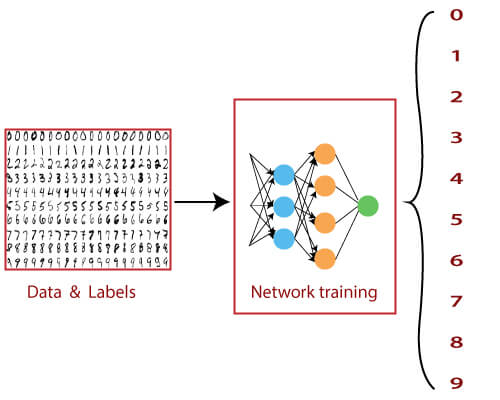